# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

## Preparation

### Key Imports

#### PyTorch
- `torch`, `torch.nn`, `torch.optim`, `DataLoader`: For building, training, and evaluating neural networks for DEA.
- `SummaryWriter`: Logs training metrics for visualization in TensorBoard.

#### Ray
- `tune`, `air`, `train`, `OptunaSearch`, `ASHAScheduler`: Used for distributed hyperparameter tuning and model optimization.

#### Data Handling & Visualization
- `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`: For data manipulation, analysis, and plotting.
- `hickle`: Efficient binary serialization format for NumPy arrays and Python objects.
- `tqdm.notebook`: Progress bars for loops, especially in Jupyter notebooks.

#### Custom Modules
- `utils`: A comprehensive set of utility functions for DEA-specific tasks like reconstruction and result logging.
- `datasets`: Dataset wrappers for different encoding schemes (Bloom Filter, Tab MinHash, Two-Step Hash).
- `pytorch_models`, `early_stopping`: Custom PyTorch model definitions and early stopping mechanism.
- `graphMatching.gma`: Executes Graph Matching Attack (GMA) to prepare DEA.



In [1]:
# Standard library
import copy
import json
import os
import string
import time
from datetime import datetime
from functools import partial

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from functools import lru_cache
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

# Ray libraries for hyperparameter tuning and parallelism
import ray
from ray import air, train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch

# Custom utilities and logic
from early_stopping.early_stopping import EarlyStopping
from graphMatching.gma import run_gma
from datasets.bloom_filter_dataset import BloomFilterDataset
from datasets.tab_min_hash_dataset import TabMinHashDataset
from datasets.two_step_hash_dataset import TwoStepHashDataset
from pytorch_models.base_model import BaseModel
from pytorch_models_hyperparameter_optimization.base_model_hyperparameter_optimization import BaseModelHyperparameterOptimization
from utils import (
    calculate_performance_metrics,
    clean_result_dict,
    create_identifier_column_dynamic,
    decode_labels_to_two_grams,
    filter_high_scoring_two_grams,
    fuzzy_reconstruction_approach,
    get_hashes,
    greedy_reconstruction,
    load_dataframe,
    lowercase_df,
    map_probabilities_to_two_grams,
    metrics_per_entry,
    print_and_save_result,
    read_header,
    reconstruct_identities_with_llm,
    reidentification_analysis,
    resolve_config,
    run_epoch,
    save_dea_runtime_log,
)

Using NumPy dot (Mac)


### Configuration Overview

#### GLOBAL_CONFIG
General control parameters for DEA runs.
- `Data`: Path to dataset (e.g., fakename_5k.tsv).
- `Overlap`: Proportion of shared entities between Alice and Eve.
- `DropFrom`: Which party (Alice, Eve or both) gets the non-overlapping entities removed.
- `MatchingMetric`, `Matching`: Used in GMA (e.g., cosine similarity, MinWeight matching).
- `Workers`: Number of parallel threads (-1 = all available).
- `BenchMode`, `DevMode`: Toggle benchmarking or development behaviors.

#### DEA_CONFIG
Training configuration for the neural network used in the Dataset Extension Attack.
- `TrainSize`, `Epochs`, `Patience`: Classic train/test split and early stopping.
- `NumSamples`: Number of tuning samples for Ray.
- `MetricToOptimize`: Metric guiding model selection (e.g., `average_dice`).
- `MatchingTechnique`: Post-processing method (e.g.,`fuzzy`, `greedy`, `ai`, `fuzzy_and_greedy`).

#### ENC_CONFIG
Controls how both Alice’s and Eve’s data are encoded.
- `AliceAlgo`, `EveAlgo`: Chosen encoding methods (BloomFilter, TabMinHash, TwoStepHash).
- Parameters are grouped by technique (BF, TMH, 2SH), but all are present to allow switching.

#### EMB_CONFIG
Defines embedding model (e.g., Node2Vec) parameters for both parties.
- `Dim`, `Context`, `Negative`: Node2Vec embedding dimensions and context window.
- `WalkLen`, `NWalks`, `P`, `Q`: Random walk hyperparameters.
- `Quantile`, `Discretize`, `Normalize`: Post-embedding processing.

#### ALIGN_CONFIG
Parameters for alignment-based reconstruction.
- `RegWS`, `RegInit`: Regularization weights.
- `NIterWS`, `NIterInit`, `NEpochWS`: Iteration limits.
- `Wasserstein`: Use Wasserstein-based alignment loss.
- `EarlyStopping`, `LRDecay`: Learning stability controls.


In [2]:
# === General Parameters ===
GLOBAL_CONFIG = {
    "Data": "./data/datasets/fakename_1k.tsv",
    "Overlap": 0.9,
    "DropFrom": "Both",
    "Verbose": False,
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": os.cpu_count() - 1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False,
    "DevMode": False,
    "BenchMode": True,
    "LoadResults": False,
    "LoadPath": "",
    "SaveResults": True,
}

# === DEA Training Parameters ===
DEA_CONFIG = {
    "TrainSize": 0.8,
    "Patience": 5,
    "MinDelta": 1e-4,
    "NumSamples": 25,
    "Epochs": 15,
    "MetricToOptimize": "average_dice",  # Options: "average_dice", "average_precision", ...
    # Fuzyy works only if first three columns resemble: givenname, surname, birthdate (dd/mm/yyyy) format (naming of columns is irellevant)
    "MatchingTechnique": "fuzzy_and_greedy",  # Options: "ai", "greedy", "fuzzy", ...
}

# === Encoding Parameters for Alice & Eve ===
ENC_CONFIG = {
    # Encoding technique
    "AliceAlgo": "BloomFilter",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "BloomFilter",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",

    # Bloom Filter specific
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,

    # Tabulation MinHash specific
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,

    # Two-Step Hashing specific
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
}

# === Embedding Configuration (e.g., Node2Vec) ===
EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42,
}

# === Graph Alignment Config ===
ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"] / 2),
    "RegInit": 1,
    "Batchsize": 1,
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5,
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True,
}

### Dictionaries

In [3]:
# Define character sets
alphabet = string.ascii_lowercase  # 'a' to 'z'
digits = string.digits             # '0' to '9'

# Generate 2-grams
letter_letter_grams = [a + b for a in alphabet for b in alphabet]   # 'aa' to 'zz'
digit_digit_grams = [d1 + d2 for d1 in digits for d2 in digits]     # '00' to '99'
letter_digit_grams = [l + d for l in alphabet for d in digits]      # 'a0' to 'z9'

# Combine all 2-gram types
all_two_grams = letter_letter_grams + letter_digit_grams + digit_digit_grams

# Map index to 2-gram string
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}


## Step 1: Load or Compute Graph Matching Attack (GMA) Results

This step ensures GMA results are available by either loading existing output files or triggering a new attack run.

1. **Start Benchmark Timing (Optional):**  
   If benchmarking is enabled (`BenchMode=True`), timers are started to measure runtime for the GMA computation.

2. **Generate Configuration Hashes:**  
   The function `get_hashes()` generates unique identifiers (hashes) based on the encoding (`ENC_CONFIG`) and embedding (`EMB_CONFIG`) settings for both Alice and Eve.  
   These hashes are concatenated into a unique string identifier to distinguish different experiment setups.

3. **Construct File Paths:**  
   The identifier is used to define expected file paths for:
   - `reidentified_individuals.h5` — records successfully linked between Eve and Alice  
   - `not_reidentified_individuals.h5` — records not matched  
   - `alice_data_complete_with_encoding.h5` — full encoded data for Alice  

4. **Check for Existing Results:**  
   If all three expected files exist, the GMA step is skipped. This avoids redundant computation.

5. **Run GMA if Needed:**  
   If any file is missing, the Graph Matching Attack is executed using `run_gma()`, which writes the results to disk using the same naming convention based on the identifier.

6. **End Benchmark Timing (Optional):**  
   If benchmarking is active, the elapsed time for the GMA step is recorded.

In [4]:
if GLOBAL_CONFIG["BenchMode"]:
    start_total = time.time()
    start_gma = time.time()

# Get absolute path to data directory
data_dir = os.path.abspath("./data")

# Generate encoding and embedding hashes for reproducible identifiers
eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash = get_hashes(
    GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG
)
identifier = f"{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}"

# Build file paths for reidentified, not reidentified, and full encoded data
path_reidentified = f"{data_dir}/available_to_eve/reidentified_individuals_{identifier}.h5"
path_not_reidentified = f"{data_dir}/available_to_eve/not_reidentified_individuals_{identifier}.h5"
path_all = f"{data_dir}/dev/alice_data_complete_with_encoding_{alice_enc_hash}.h5"

# Run GMA only if the expected output files do not yet exist
if not (
    os.path.isfile(path_reidentified)
    and os.path.isfile(path_not_reidentified)
    and os.path.isfile(path_all)
):
    run_gma(
        GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG, DEA_CONFIG,
        eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash
    )

if GLOBAL_CONFIG["BenchMode"]:
    elapsed_gma = time.time() - start_gma


Correct: 3000 of 3000
Success rate: 1.000000


## Step 2: Prepare Training, Validation, and Test Data

This step prepares the datasets needed for training and evaluation of the Dataset Extension Attack (DEA).  
Depending on the selected encoding algorithm and available data, different dataset loaders are used.

1. **Start Benchmark Timing (Optional):**  
   If `BenchMode` is enabled, a timer is started to track the time spent in data preparation.

2. **Load Reidentified and Not Reidentified Data:**  
   - `reidentified_individuals_*.h5`: Contains entities successfully linked by the Graph Matching Attack.
   - `not_reidentified_individuals_*.h5` and `alice_data_complete_with_encoding_*.h5`:  
     Used to construct a labeled test set of entities not reidentified by the GMA.

3. **Select Dataset Type Based on Encoding:**
   - If `AliceAlgo` is set to `"BloomFilter"`: `BloomFilterDataset` is used.
   - If `TabMinHash`: `TabMinHashDataset` is used.
   - If `TwoStepHash`: `TwoStepHashDataset` is used with integer feature vectors.

4. **Split Labeled Data into Train and Validation Sets:**  
   The reidentified dataset is split according to `DEA_CONFIG["TrainSize"]`.

5. **Return Datasets:**  
   The function returns:
   - `data_train`: for model training  
   - `data_val`: for validation during training  
   - `data_test` (optional): for evaluating the reconstruction on not reidentified entities

6. **Drop Redundant Columns (if needed):**  
   The function `load_not_reidentified_data()` ensures compatibility of test data by removing unnecessary columns.

7. **End Benchmark Timing (Optional):**  
   If benchmarking is active, the elapsed time for data preparation is recorded.

In [5]:
def get_cache_path(data_directory, identifier, alice_enc_hash, name="dataset"):
    os.makedirs(f"{data_directory}/cache", exist_ok=True)
    return os.path.join(data_directory, "cache", f"{name}_{identifier}_{alice_enc_hash}.pkl")

def load_data(data_directory, alice_enc_hash, identifier, load_test=False):
    cache_path = get_cache_path(data_directory, identifier, alice_enc_hash)

    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            data_train, data_val, data_test = pickle.load(f)
        return data_train, data_val, data_test

    # Load from raw files
    df_reidentified = load_dataframe(f"{data_directory}/available_to_eve/reidentified_individuals_{identifier}.h5")

    df_test = None
    if load_test:
        df_not_reidentified = load_dataframe(f"{data_directory}/available_to_eve/not_reidentified_individuals_{identifier}.h5")
        df_all = load_dataframe(f"{data_directory}/dev/alice_data_complete_with_encoding_{alice_enc_hash}.h5")
        df_test = df_all[df_all["uid"].isin(df_not_reidentified["uid"])].reset_index(drop=True)

    def get_encoding_dataset_class():
        algo = ENC_CONFIG["AliceAlgo"]
        if algo == "BloomFilter":
            return BloomFilterDataset
        elif algo == "TabMinHash":
            return TabMinHashDataset
        elif algo == "TwoStepHash":
            return TwoStepHashDataset
        else:
            raise ValueError(f"Unknown encoding algorithm: {algo}")

    DatasetClass = get_encoding_dataset_class()

    if ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
        unique_ints = sorted(set().union(*df_reidentified["twostephash"]))
        dataset_args = {"all_integers": unique_ints}
    else:
        dataset_args = {}

    common_args = {
        "is_labeled": True,
        "all_two_grams": all_two_grams,
        "dev_mode": GLOBAL_CONFIG["DevMode"]
    }

    data_labeled = DatasetClass(df_reidentified, **common_args, **dataset_args)
    data_test = DatasetClass(df_test, **common_args, **dataset_args) if load_test else None

    train_size = int(DEA_CONFIG["TrainSize"] * len(data_labeled))
    val_size = len(data_labeled) - train_size
    data_train, data_val = random_split(data_labeled, [train_size, val_size])

    # Save to cache
    with open(cache_path, 'wb') as f:
        pickle.dump((data_train, data_val, data_test), f)
    return data_train, data_val, data_test


def load_not_reidentified_data(data_directory, alice_enc_hash, identifier):
        cache_path = get_cache_path(data_directory, identifier, alice_enc_hash, name="not_reidentified")
        if os.path.exists(cache_path):
            with open(cache_path, 'rb') as f:
                df_filtered = pickle.load(f)
            return df_filtered

        df_not_reidentified = load_dataframe(f"{data_directory}/available_to_eve/not_reidentified_individuals_{identifier}.h5")
        df_all = load_dataframe(f"{data_directory}/dev/alice_data_complete_with_encoding_{alice_enc_hash}.h5")

        df_filtered = df_all[df_all["uid"].isin(df_not_reidentified["uid"])].reset_index(drop=True)



        # Drop column by name instead of position if possible
        drop_col = df_filtered.columns[-2]
        df_filtered = df_filtered.drop(columns=[drop_col])

        with open(cache_path, 'wb') as f:
            pickle.dump(df_filtered, f)

        return df_filtered



In [6]:
selected_dataset = GLOBAL_CONFIG["Data"].split("/")[-1].replace(".tsv", "")
experiment_tag = "experiment_" + ENC_CONFIG["AliceAlgo"] + "_" + selected_dataset + "_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_to = f"experiment_results/{experiment_tag}"
os.makedirs(save_to, exist_ok=True)

# Combine all configs into one dictionary
all_configs = {
    "GLOBAL_CONFIG": GLOBAL_CONFIG,
    "DEA_CONFIG": DEA_CONFIG,
    "ENC_CONFIG": ENC_CONFIG,
    "EMB_CONFIG": EMB_CONFIG,
    "ALIGN_CONFIG": ALIGN_CONFIG
}

# Save as a readable .txt file
with open(os.path.join(save_to, "config.txt"), "w") as f:
    for config_name, config_dict in all_configs.items():
        f.write(f"# === {config_name} ===\n")
        f.write(json.dumps(config_dict, indent=4))
        f.write("\n\n")
os.makedirs(f"{save_to}/hyperparameteroptimization", exist_ok=True)

In [7]:
data_train, data_val, data_test = load_data(data_dir, alice_enc_hash, identifier, load_test=True)
df_not_reidentified = load_not_reidentified_data(data_dir, alice_enc_hash, identifier)
# Exit the function if any of the data frames are empty
if len(data_train) == 0 or len(data_val) == 0 or len(data_test) == 0 or df_not_reidentified.empty:
    log_path = os.path.join(save_to, "termination_log.txt")
    with open(log_path, "w") as f:
        f.write("Training process canceled due to empty dataset.\n")
        f.write(f"Length of data_train: {len(data_train)}\n")
        f.write(f"Length of data_val: {len(data_val)}\n")
        f.write(f"Length of data_test: {len(data_test)}\n")
        f.write(f"Length of df_not_reidentified: {len(df_not_reidentified)}\n")
    print("One or more datasets are empty. Termination log written.")

## Step 3: Hyperparameter Optimization

In [8]:
if GLOBAL_CONFIG["BenchMode"]:
    start_hyperparameter_optimization = time.time()

In [9]:
def train_model(config, data_dir, output_dim, alice_enc_hash, identifier, patience, min_delta):
    # Create DataLoaders for training, validation, and testing

    data_train, data_val, _ = load_data(data_dir, alice_enc_hash, identifier, load_test=False)

    input_dim = data_train[0][0].shape[0]  # Get the input dimension from the first sample

    dataloader_train = DataLoader(
        data_train,
        batch_size=int(config["batch_size"]),
        shuffle=True,  # Important for training
    )

    dataloader_val = DataLoader(
        data_val,
        batch_size=int(config["batch_size"]),
        shuffle=False,
    )

    best_val_loss = float('inf')
    best_model_state = None

    train_losses = []
    val_losses = []
    total_precision = total_recall = total_f1 = total_dice = total_val_loss = 0.0
    num_samples = 0
    epochs = 0
    early_stopper = EarlyStopping(patience=patience, min_delta=min_delta)

    # Define and initialize model with hyperparameters from config
    model = BaseModelHyperparameterOptimization(
        input_dim=input_dim,
        output_dim=output_dim,
        num_layers=config["num_layers"],
        hidden_layer_size=config["hidden_layer_size"],
        dropout_rate=config["dropout_rate"],
        activation_fn=config["activation_fn"]
    )

    # Set device for model (GPU or CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Select loss function based on config
    loss_functions = {
        "BCEWithLogitsLoss": nn.BCEWithLogitsLoss(),
        "MultiLabelSoftMarginLoss": nn.MultiLabelSoftMarginLoss(),
        "SoftMarginLoss": nn.SoftMarginLoss(),
    }
    criterion = loss_functions[config["loss_fn"]]

    learning_rate = config["optimizer"]["lr"].sample()
    # Select optimizer based on config
    optimizers = {
        "Adam": lambda: optim.Adam(model.parameters(), lr=learning_rate),
        "AdamW": lambda: optim.AdamW(model.parameters(), lr=learning_rate),
        "SGD": lambda: optim.SGD(model.parameters(), lr=learning_rate, momentum=config["optimizer"]["momentum"].sample()),
        "RMSprop": lambda: optim.RMSprop(model.parameters(), lr=learning_rate)
    }
    optimizer = optimizers[config["optimizer"]["name"]]()

    schedulers = {
        "StepLR": lambda: torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=config["lr_scheduler"]["step_size"].sample(),
            gamma=config["lr_scheduler"]["gamma"].sample()
        ),
        "ExponentialLR": lambda: torch.optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma=config["lr_scheduler"]["gamma"].sample()
        ),
        "ReduceLROnPlateau": lambda: torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=config["lr_scheduler"]["mode"],
            factor=config["lr_scheduler"]["factor"].sample(),
            patience=config["lr_scheduler"]["patience"].sample()
        ),
        "CosineAnnealingLR": lambda: torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=config["lr_scheduler"]["T_max"].sample(),
            eta_min=config["lr_scheduler"]["eta_min"].sample()
        ),
        "CyclicLR": lambda: torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=config["lr_scheduler"]["base_lr"].sample(),
            max_lr=config["lr_scheduler"]["max_lr"].sample(),
            step_size_up=config["lr_scheduler"]["step_size_up"].sample(),
            mode=config["lr_scheduler"]["mode_cyclic"].sample(),
            cycle_momentum=False
        ),
        "None": lambda: None,
    }
    scheduler = schedulers[config["lr_scheduler"]["name"]]()

    # Training loop
    for _ in range(DEA_CONFIG["Epochs"]):
        epochs += 1
        # Training phase
        model.train()
        train_loss = run_epoch(model, dataloader_train, criterion, optimizer, device, is_training=True, verbose=GLOBAL_CONFIG["Verbose"], scheduler=scheduler)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = run_epoch(model, dataloader_val, criterion, optimizer, device, is_training=False, verbose=GLOBAL_CONFIG["Verbose"], scheduler=scheduler)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        val_losses.append(val_loss)
        total_val_loss += val_loss

         # Early stopping check
        if early_stopper(val_loss):
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    # Test phase with reconstruction and evaluation
    model.eval()

    with torch.no_grad():
        for data, labels, _ in dataloader_val:

            actual_two_grams = decode_labels_to_two_grams(two_gram_dict, labels)

            # Move data to device and make predictions
            data = data.to(device)
            logits = model(data)
            probabilities = torch.sigmoid(logits)

            # Convert probabilities into 2-gram scores
            batch_two_gram_scores = map_probabilities_to_two_grams(two_gram_dict, probabilities)

            # Filter out low-scoring 2-grams
            batch_filtered_two_gram_scores = filter_high_scoring_two_grams(batch_two_gram_scores, config["threshold"])

            # Calculate performance metrics for evaluation
            dice, precision, recall, f1 = calculate_performance_metrics(
                actual_two_grams, batch_filtered_two_gram_scores)

            total_dice += dice
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            num_samples += data.size(0) # Batch Size

    train.report({
            "average_dice": total_dice / num_samples,
            "average_precision": total_precision / num_samples,
            "average_recall": total_recall / num_samples,
            "average_f1": total_f1 / num_samples,
            "total_val_loss": total_val_loss,
            "len_train": len(dataloader_train.dataset),
            "len_val": len(dataloader_val.dataset),
            "epochs": epochs
        })

In [10]:
# Define search space for hyperparameter optimization
search_space = {
    "output_dim": len(all_two_grams),  # Output dimension is also the number of unique 2-grams
    "num_layers": tune.randint(1, 4),  # Vary the number of layers in the model
    #"num_layers": tune.randint(1, 2),
    "hidden_layer_size": tune.choice([128, 256, 512, 1024, 2048]),  # Different sizes for hidden layers
    #"hidden_layer_size": tune.choice([1024, 2048]),  # Different sizes for hidden layers
    "dropout_rate": tune.uniform(0.1, 0.4),  # Dropout rate between 0.1 and 0.4
    "activation_fn": tune.choice(["relu", "leaky_relu", "gelu", "elu", "selu", "tanh"]),  # Activation functions to choose from
    "optimizer": tune.choice([
        {"name": "Adam", "lr": tune.loguniform(1e-5, 1e-3)},
        {"name": "AdamW", "lr": tune.loguniform(1e-5, 1e-3)},
        {"name": "SGD", "lr": tune.loguniform(1e-4, 1e-2), "momentum": tune.uniform(0.0, 0.99)},
        {"name": "RMSprop", "lr": tune.loguniform(1e-5, 1e-3)},
    ]),
    "loss_fn": tune.choice(["BCEWithLogitsLoss", "MultiLabelSoftMarginLoss", "SoftMarginLoss"]),
    "threshold": tune.uniform(0.3, 0.8),
    "lr_scheduler": tune.choice([
        {"name": "StepLR", "step_size": tune.choice([5, 10, 20]), "gamma": tune.uniform(0.1, 0.9)},
        {"name": "ExponentialLR", "gamma": tune.uniform(0.85, 0.99)},
        {"name": "ReduceLROnPlateau", "mode": "min", "factor": tune.uniform(0.1, 0.5), "patience": tune.choice([5, 10, 15])},
        {"name": "CosineAnnealingLR", "T_max": tune.loguniform(10, 50) , "eta_min": tune.choice([1e-5, 1e-6, 0])},
        {"name": "CyclicLR", "base_lr": tune.loguniform(1e-5, 1e-3), "max_lr": tune.loguniform(1e-3, 1e-1), "step_size_up": tune.choice([2000, 4000]), "mode_cyclic": tune.choice(["triangular", "triangular2", "exp_range"]) },
        {"name": "None"}  # No scheduler
    ]),
    "batch_size": tune.choice([8, 16, 32, 64]),  # Batch sizes to test
}

# Initialize Ray for hyperparameter optimization
ray.init(ignore_reinit_error=True, logging_level="ERROR")

# Optuna Search Algorithm for optimizing the hyperparameters
optuna_search = OptunaSearch(metric=DEA_CONFIG["MetricToOptimize"], mode="max")

# Use ASHAScheduler to manage trials and early stopping
scheduler = ASHAScheduler(metric="total_val_loss", mode="min")



# Define and configure the Tuner for Ray Tune
tuner = tune.Tuner(
    partial(train_model, data_dir=data_dir, output_dim=len(all_two_grams),alice_enc_hash=alice_enc_hash, identifier=identifier, patience=DEA_CONFIG["Patience"], min_delta=DEA_CONFIG["MinDelta"]),  # The function to optimize (training function)
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,  # Search strategy using Optuna
        scheduler=scheduler,  # Use ASHA to manage the trials
        num_samples=DEA_CONFIG["NumSamples"],  # Number of trials to run
        max_concurrent_trials=GLOBAL_CONFIG["Workers"],
    ),
    param_space=search_space  # Pass in the defined hyperparameter search space

)

# Run the tuner
results = tuner.fit()

# Shut down Ray after finishing the optimization
ray.shutdown()

In [11]:
result_grid = results
best_result = result_grid.get_best_result(metric=DEA_CONFIG["MetricToOptimize"], mode="max")

In [12]:
if GLOBAL_CONFIG["BenchMode"]:
    elapsed_hyperparameter_optimization = time.time() - start_hyperparameter_optimization

In [13]:
if GLOBAL_CONFIG["SaveResults"]:
    worst_result = result_grid.get_best_result(metric=DEA_CONFIG["MetricToOptimize"], mode="min")

    # Combine configs and metrics into a DataFrame
    df = pd.DataFrame([
        {
            **clean_result_dict(resolve_config(result.config)),
            **{k: result.metrics.get(k) for k in ["average_dice", "average_precision", "average_recall", "average_f1"]},
        }
        for result in result_grid
    ])

    # Save to CSV
    df.to_csv(f"{save_to}/hyperparameteroptimization/all_trial_results.csv", index=False)
    print("✅ Results saved to all_trial_results.csv")

    print_and_save_result("Best_Result", best_result, f"{save_to}/hyperparameteroptimization")
    print_and_save_result("Worst_Result", worst_result, f"{save_to}/hyperparameteroptimization")

    # Compute and print average metrics
    print("\n📊 Average Metrics Across All Trials")
    avg_metrics = df[["average_dice", "average_precision", "average_recall", "average_f1"]].mean()
    print("-" * 40)
    for key, value in avg_metrics.items():
        print(f"{key.capitalize()}: {value:.4f}")

    # --- 📈 Plotting performance metrics ---
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[["average_dice", "average_recall", "average_f1", "average_precision"]])
    plt.title("Distribution of Performance Metrics Across Trials")
    plt.grid(True)
    plt.savefig(f"{save_to}/hyperparameteroptimization/metric_distributions.png")
    plt.close()
    print("📊 Saved plot: metric_distributions.png")

    # --- 📌 Correlation between config params and performance ---
    # Only include numeric config columns
    exclude_cols = {"input_dim", "output_dim"}
    numeric_config_cols = [
        col for col in df.columns
        if pd.api.types.is_numeric_dtype(df[col]) and col not in exclude_cols
    ]
    correlation_df = df[numeric_config_cols].corr()

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Between Parameters and Metrics")
    plt.tight_layout()
    plt.savefig(f"{save_to}/hyperparameteroptimization/correlation_heatmap.png")
    plt.close()
    print("📌 Saved heatmap: correlation_heatmap.png")


✅ Results saved to all_trial_results.csv

🔍 Best_Result
----------------------------------------
Config: {'output_dim': 1036, 'num_layers': 2, 'hidden_layer_size': 2048, 'dropout_rate': 0.1819677527081685, 'activation_fn': 'elu', 'optimizer': {'name': 'AdamW', 'lr': 2.0010766161326e-05}, 'loss_fn': 'MultiLabelSoftMarginLoss', 'threshold': 0.4210017125168848, 'lr_scheduler': {'name': 'CosineAnnealingLR', 'T_max': 10.52894340497391, 'eta_min': 0}, 'batch_size': 16}
Average Dice: 0.8768
Average Precision: 0.9538
Average Recall: 0.8170
Average F1: 0.8768

🔍 Worst_Result
----------------------------------------
Config: {'output_dim': 1036, 'num_layers': 2, 'hidden_layer_size': 256, 'dropout_rate': 0.11688479553741313, 'activation_fn': 'tanh', 'optimizer': {'name': 'SGD', 'lr': 0.00837722176045546, 'momentum': 0.09800032051895437}, 'loss_fn': 'BCEWithLogitsLoss', 'threshold': 0.7576008268959075, 'lr_scheduler': {'name': 'ReduceLROnPlateau', 'mode': 'min', 'factor': 0.45185760345859116, 'pati

## Step 4: Model Training

The neural network model is selected dynamically based on the encoding technique used for Alice’s data.

### Supported Models:

- **BloomFilter** → `BloomFilterToTwoGramClassifier`  
  - Input: Binary vector (Bloom filter)  
  - Output: 2-gram prediction

- **TabMinHash** → `TabMinHashToTwoGramClassifier`  
  - Input: Tabulated MinHash signature  
  - Output: 2-gram prediction

- **TwoStepHash** → `TwoStepHashToTwoGramClassifier`  
  - Input: Length of the unique integers present
  - Output: 2-gram predicition
    
Each model outputs predictions over the set of all possible 2-grams (`all_two_grams`), and the input dimension is dynamically configured based on the dataset.


In [14]:
if GLOBAL_CONFIG["BenchMode"]:
    start_model_training = time.time()

In [15]:
best_config = resolve_config(best_result.config)
data_train, data_val, data_test = load_data(data_dir, alice_enc_hash, identifier, load_test=True)
input_dim=data_train[0][0].shape[0]

dataloader_train = DataLoader(
    data_train,
    batch_size=int(best_config.get("batch_size", 32)),  # Default to 32 if not specified
    shuffle=True  # Important for training
)

dataloader_val = DataLoader(
    data_val,
    batch_size=int(best_config.get("batch_size", 32)),
    shuffle=False  # Allows variation in validation batches
)

dataloader_test = DataLoader(
    data_test,
    batch_size=int(best_config.get("batch_size", 32)),
    shuffle=False  # Allows variation in validation batches
)

In [16]:
model = BaseModel(
            input_dim=input_dim,
            output_dim=len(all_two_grams),
            hidden_layer=best_config.get("hidden_layer_size", 128),  # Default to 128 if not specified
            num_layers=best_config.get("num_layers", 2),  # Default to 2 if not specified
            dropout_rate=best_config.get("dropout_rate", 0.2),  # Default to 0.2 if not specified
            activation_fn=best_config.get("activation_fn", "relu")  # Default to 'relu' if not specified
        )
print(model)

BaseModel(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.1819677527081685, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.1819677527081685, inplace=False)
    (6): Linear(in_features=2048, out_features=1036, bias=True)
  )
)


## Training Environment Setup
This code initializes the core components needed for training a neural network model.

1. TensorBoard Setup
    - Creates unique run name by combining:
    - Loss function type
    - Optimizer choice
    - Alice's algorithm
    - Initializes TensorBoard writer in runs directory
2. Device Configuration
    - Automatically selects GPU if available, falls back to CPU
    - Moves model to selected device
3. Loss Functions
    - `BCEWithLogitsLoss`: Binary Cross Entropy with Logits
    - `MultiLabelSoftMarginLoss`: Multi-Label Soft Margin Loss
4. Optimizers:
    - `Adam`: Adaptive Moment Estimation
    - `AdamW`: Adam with Weight Decay
    - `SGD`: Stochastic Gradient Descent (with momentum)
    - `RMSprop`: Root Mean Square Propagation

In [17]:
if GLOBAL_CONFIG["SaveResults"]:
    # Setup tensorboard logging
    run_name = "".join([
        best_config.get("loss_fn", "MultiLabelSoftMarginLoss"),
        best_config.get("optimizer").get("name", "Adam"),
        ENC_CONFIG["AliceAlgo"],
        best_config.get("activation_fn", "relu"),
    ])
    tb_writer = SummaryWriter(f"{save_to}/{run_name}")

# Setup compute device (GPU/CPU)
compute_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(compute_device)

# Initialize loss function
match best_config.get("loss_fn", "MultiLabelSoftMarginLoss"):
    case "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss(reduction='mean')
    case "MultiLabelSoftMarginLoss":
        criterion = nn.MultiLabelSoftMarginLoss(reduction='mean')
    case "SoftMarginLoss":
        criterion = nn.SoftMarginLoss()
    case _:
        raise ValueError(f"Unsupported loss function: {best_config.get('loss_fn', 'MultiLabelSoftMarginLoss')}")

# Initialize optimizer
match best_config.get("optimizer").get("name", "Adam"):
    case "Adam":
        optimizer = optim.Adam(model.parameters(), lr=best_config.get("optimizer").get("lr"))
    case "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=best_config.get("optimizer").get("lr"))
    case "SGD":
        optimizer = optim.SGD(model.parameters(),
                            lr=best_config.get("optimizer").get("lr"),
                            momentum=best_config.get("optimizer").get("momentum"))
    case "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=best_config.get("optimizer").get("lr"))
    case _:
        raise ValueError(f"Unsupported optimizer: {best_config.get('optimizer').get('name', 'Adam')}")

# Initialize learning rate scheduler
match best_config.get("lr_scheduler").get("name", "None"):
    case "StepLR":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=best_config.get("lr_scheduler").get("step_size"),
            gamma=best_config.get("lr_scheduler").get("gamma")
        )
    case "ExponentialLR":
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma=best_config.get("lr_scheduler").get("gamma")
        )
    case "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=best_config.get("lr_scheduler").get("mode"),
            factor=best_config.get("lr_scheduler").get("factor"),
            patience=best_config.get("lr_scheduler").get("patience")
        )
    case "CosineAnnealingLR":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=best_config.get("lr_scheduler").get("T_max")
        )
    case "CyclicLR":
        scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=best_config.get("lr_scheduler").get("base_lr"),
            max_lr=best_config.get("lr_scheduler").get("max_lr"),
            step_size_up=best_config.get("lr_scheduler").get("step_size_up"),
            mode=best_config.get("lr_scheduler").get("mode_cyclic"),
            cycle_momentum=False  # usually False for Adam/AdamW
        )
    case None | "None":
        scheduler = None
    case _:
        raise ValueError(f"Unsupported LR scheduler: {best_config.get('lr_scheduler').get('name', 'None')}")

## Model Training with Early Stopping

The function `train_model` orchestrates the training process for the neural network, including both training and validation phases for each epoch. It also utilizes **early stopping** to halt training when the validation loss fails to improve over multiple epochs, avoiding overfitting.

### Key Phases:
1. **Training Phase**: 
   - The model is trained on the `dataloader_train`, computing the training loss using the specified loss function (`criterion`) and optimizer. Gradients are calculated, and the model parameters are updated.
  
2. **Validation Phase**:
   - The model is evaluated on the `dataloader_val` without updating weights. The validation loss is computed to track model performance on unseen data.

3. **Logging**: 
   - Training and validation losses are logged to both the console and **TensorBoard** for tracking model performance during training.

4. **Early Stopping**: 
   - If the validation loss does not improve after a certain number of epochs (defined by `DEA_CONFIG["Patience"]`), the training process is halted to prevent overfitting.

### Helper Functions:
- `run_epoch`: Handles a single epoch, either for training or validation, depending on the flag `is_training`.
- `log_metrics`: Logs the training and validation losses to the console and TensorBoard for each epoch.


In [18]:
def _log_epoch_metrics(epoch, total_epochs, train_loss, val_loss):
    epoch_str = f"[{epoch + 1}/{total_epochs}]"
    print(f"{epoch_str} 🔧 Train Loss: {train_loss:.4f} | 🔍 Val Loss: {val_loss:.4f}")

    if DEA_CONFIG.get("SaveResults", False) and 'tb_writer' in globals():
        tb_writer.add_scalar("Loss/train", train_loss, epoch + 1)
        tb_writer.add_scalar("Loss/validation", val_loss, epoch + 1)

In [19]:
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device, scheduler=None):
    num_epochs = best_config.get("epochs", DEA_CONFIG["Epochs"])
    verbose = GLOBAL_CONFIG["Verbose"]
    patience = DEA_CONFIG["Patience"]
    min_delta = DEA_CONFIG["MinDelta"]
    best_val_loss = float('inf')
    best_model_state = None


    early_stopper = EarlyStopping(patience=patience, min_delta=min_delta, verbose=verbose)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        train_loss = run_epoch(
            model, dataloader_train, criterion, optimizer,
            device, is_training=True, verbose=verbose, scheduler=scheduler
        )
        train_losses.append(train_loss)

        # ---- Validation ----
        model.eval()
        with torch.no_grad():
            val_loss = run_epoch(
                model, dataloader_val, criterion, optimizer,
                device, is_training=False, verbose=verbose, scheduler=scheduler
            )
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())

        val_losses.append(val_loss)

        # ---- Scheduler step ----
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)

        # ---- Logging ----
        _log_epoch_metrics(epoch, num_epochs, train_loss, val_loss)

        # ---- Early stopping ----
        if early_stopper(val_loss):
            if verbose:
                print(f"⏹️ Early stopping triggered at epoch {epoch + 1}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses


In [20]:
model, train_losses, val_losses = train_model(
    model, dataloader_train, dataloader_val,
    criterion, optimizer, compute_device,
    scheduler=scheduler
)

[1/15] 🔧 Train Loss: 0.3276 | 🔍 Val Loss: 0.0705
[2/15] 🔧 Train Loss: 0.0676 | 🔍 Val Loss: 0.0650
[3/15] 🔧 Train Loss: 0.0652 | 🔍 Val Loss: 0.0641
[4/15] 🔧 Train Loss: 0.0647 | 🔍 Val Loss: 0.0638
[5/15] 🔧 Train Loss: 0.0642 | 🔍 Val Loss: 0.0634
[6/15] 🔧 Train Loss: 0.0640 | 🔍 Val Loss: 0.0632
[7/15] 🔧 Train Loss: 0.0636 | 🔍 Val Loss: 0.0629
[8/15] 🔧 Train Loss: 0.0633 | 🔍 Val Loss: 0.0626
[9/15] 🔧 Train Loss: 0.0629 | 🔍 Val Loss: 0.0622
[10/15] 🔧 Train Loss: 0.0625 | 🔍 Val Loss: 0.0618
[11/15] 🔧 Train Loss: 0.0620 | 🔍 Val Loss: 0.0614
[12/15] 🔧 Train Loss: 0.0615 | 🔍 Val Loss: 0.0610
[13/15] 🔧 Train Loss: 0.0608 | 🔍 Val Loss: 0.0604
[14/15] 🔧 Train Loss: 0.0602 | 🔍 Val Loss: 0.0597
[15/15] 🔧 Train Loss: 0.0592 | 🔍 Val Loss: 0.0589


In [21]:
if GLOBAL_CONFIG["BenchMode"]:
    elapsed_model_training = time.time() - start_model_training

## Loss Visualization over Epochs

This code snippet generates a plot to visualize the **training loss** and **validation loss** across epochs. It's useful for tracking model performance during training and evaluating if overfitting is occurring (i.e., when validation loss starts increasing while training loss continues to decrease).

### Key Elements:
1. **Plotting the Losses**: 
   - The `train_losses` and `val_losses` are plotted over the epochs. 
   - The **blue line** represents the training loss, and the **red line** represents the validation loss.

2. **Legend**: 
   - A legend is added to distinguish between training and validation losses.

3. **Title and Labels**: 
   - The plot is titled "Training and Validation Loss over Epochs" for context.
   - **X-axis** represents the epoch number, and **Y-axis** represents the loss value.


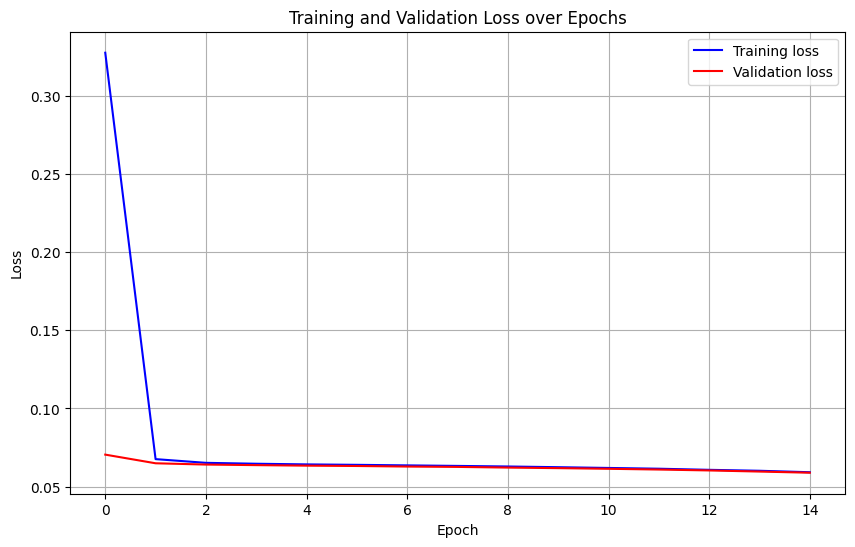

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training loss', color='blue')
plt.plot(val_losses, label='Validation loss', color='red')
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

if DEA_CONFIG.get("SaveResults", False):
    plt.savefig(f"{save_to}/loss_curve.png")
    plt.close()
    print("📉 Saved loss curve to loss_curve.png")


## Step 5: Application to Encoded Data

This code performs inference on the test data and compares the predicted 2-grams with the actual 2-grams, providing a performance evaluation based on the **Dice similarity coefficient**.

### Key Steps:

1. **Prepare for Evaluation**:
   - The model is switched to **evaluation mode** (`model.eval()`), ensuring no gradient computation.
   
2. **Thresholding**:
   - A threshold (`DEA_CONFIG["FilterThreshold"]`) is applied to filter out low-probability predictions, retaining only the most confident predictions.

3. **Inference and 2-Gram Scoring**:
   - The model is applied to the batch, and the **logits** are converted into probabilities using the **sigmoid function**.
   - The probabilities are then mapped to **2-gram scores**, and scores below the threshold are discarded.

4. **Reconstructing Words**:
   - For each sample in the batch, **2-grams** are reconstructed into words based on the filtered scores.

5. **Performance Metrics**:
   - The actual 2-grams (from the test dataset) are compared with the predicted 2-grams, and the **Dice similarity coefficient** is calculated for each sample.

### Result:
- The code generates a list `combined_results_performance`, which contains a detailed comparison for each UID, including:
  - **Actual 2-grams** (from the test data)
  - **Predicted 2-grams** (from the model)
  - **Dice similarity** score indicating how similar the actual and predicted 2-grams are.

In [23]:
base_path = os.path.join(
    GLOBAL_CONFIG["LoadPath"] if GLOBAL_CONFIG["LoadResults"] else save_to,
    "trained_model"
)
model_file   = f"{base_path}/model.pt"
config_file  = f"{base_path}/config.json"
result_file  = f"{base_path}/result.json"
metrics_file = f"{base_path}/metrics.txt"


In [24]:
def save_model_and_config(model, config, path):
    os.makedirs(path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(path, "model.pt"))
    with open(os.path.join(path, "config.json"), "w") as f:
        json.dump(config, f, indent=4)
    print(f"✅ Saved model and config to {path}")


def load_model_and_config(model_cls, path, input_dim, output_dim):
    with open(os.path.join(path, "config.json")) as f:
        config = json.load(f)

    model = model_cls(
        input_dim=input_dim,
        output_dim=output_dim,
        hidden_layer=config.get("hidden_layer_size", 128),
        num_layers=config.get("num_layers", 2),
        dropout_rate=config.get("dropout_rate", 0.2),
        activation_fn=config.get("activation_fn", "relu")
    )
    model.load_state_dict(torch.load(os.path.join(path, "model.pt")))
    model.eval()
    return model, config


In [25]:
if GLOBAL_CONFIG["SaveResults"]:
    save_model_and_config(model, best_config, base_path)

if GLOBAL_CONFIG["LoadResults"]:
    #TODO: how to figure out input_dim without loading dataset
    model, best_config = load_model_and_config(BaseModel, base_path, input_dim=1024, output_dim=len(all_two_grams))
    model.to(compute_device)

✅ Saved model and config to experiment_results/experiment_BloomFilter_fakename_5k_2025-07-07_16-21-34/trained_model


In [26]:
if GLOBAL_CONFIG["BenchMode"]:
    start_application_to_encoded_data = time.time()

In [27]:
# Initialize metric accumulators
total_dice = total_precision = total_recall = total_f1 = 0.0
num_samples = 0
results = []

threshold = best_config.get("threshold", 0.5)
model.eval()

# Progress bar only if verbose
dataloader_iter = tqdm(dataloader_test, desc="Test loop") if GLOBAL_CONFIG["Verbose"] else dataloader_test

with torch.no_grad():
    for data, labels, uids in dataloader_iter:
        data, labels = data.to(compute_device), labels.to(compute_device)

        logits = model(data)
        probs = torch.sigmoid(logits)

        # Actual and predicted 2-grams
        actual_two_grams = decode_labels_to_two_grams(two_gram_dict, labels)
        predicted_scores = map_probabilities_to_two_grams(two_gram_dict, probs)
        predicted_filtered = filter_high_scoring_two_grams(predicted_scores, threshold)

        # Batch metrics
        bs = data.size(0)
        dice, precision, recall, f1 = calculate_performance_metrics(actual_two_grams, predicted_filtered)

        total_dice += dice
        total_precision += precision
        total_recall += recall
        total_f1 += f1
        num_samples += bs

        # Store per-sample predictions
        for uid, actual, predicted in zip(uids, actual_two_grams, predicted_filtered):
            metrics = metrics_per_entry(actual, predicted)
            results.append({
                "uid": uid,
                "actual_two_grams": actual,
                "predicted_two_grams": predicted,
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1": metrics["f1"],
                "dice": metrics["dice"],
                "jaccard": metrics["jaccard"]
            })

# Avoid division by zero
if num_samples > 0:
    avg_dice = total_dice / num_samples
    avg_precision = total_precision / num_samples
    avg_recall = total_recall / num_samples
    avg_f1 = total_f1 / num_samples
else:
    avg_dice = avg_precision = avg_recall = avg_f1 = 0.0

# Logging
print(f"\n📊 Final Test Metrics:")
print(f"  Dice:      {avg_dice:.4f}")
print(f"  Precision: {avg_precision:.4f}")
print(f"  Recall:    {avg_recall:.4f}")
print(f"  F1 Score:  {avg_f1:.4f}")



📊 Final Test Metrics:
  Dice:      0.1208
  Precision: 0.9477
  Recall:    0.0651
  F1 Score:  0.1208


In [28]:
if GLOBAL_CONFIG["BenchMode"]:
    elapsed_application_to_encoded_data = time.time() - start_application_to_encoded_data

In [29]:
# SAVE - Metrics and Result
if GLOBAL_CONFIG["SaveResults"]:
    with open(metrics_file, "w") as f:
        f.write(f"Average Precision: {avg_precision:.4f}\n")
        f.write(f"Average Recall: {avg_recall:.4f}\n")
        f.write(f"Average F1 Score: {avg_f1:.4f}\n")
        f.write(f"Average Dice Similarity: {avg_dice:.4f}\n")

    with open(result_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)


In [30]:
# LOAD - Result
if GLOBAL_CONFIG["LoadResults"]:
    with open(result_file, 'r', encoding='utf-8') as f:
        result = json.load(f)


## Visualize Performance for Re-Identification

In [31]:
results_df = pd.json_normalize(results) # ≈2× faster than DataFrame(list)

metric_cols = ["precision", "recall", "f1", "dice", "jaccard"]        # keys created earlier
melted = results_df.melt(value_vars=metric_cols,
                         var_name="metric",
                         value_name="score")

plt.figure(figsize=(10, 6))
sns.histplot(data=melted,
             x="score",
             hue="metric",
             bins=20,
             element="step",
             fill=False,
             kde=True,
             palette="Set2")
plt.title("Distribution of Precision / Recall / F1 across Samples")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()

if DEA_CONFIG.get("SaveResults", False):
    plt.savefig(f"{save_to}/metric_distributions.png")
    print("📊  Saved plot: metric_distributions.png")

plt.close()

print("\n🔍 Sample Reconstructions (first 5)")
for _, row in results_df.iloc[:5].iterrows():
    print(f"UID: {row.uid}")
    print(f"  Actual 2-grams:    {row.actual_two_grams}")
    print(f"  Predicted 2-grams: {row.predicted_two_grams}")
    print("-" * 60)



🔍 Sample Reconstructions (first 5)
UID: 96557
  Actual 2-grams:    ['az', 'di', 'ia', 'll', 'ly', 'mo', 'ol', 'yd', 'z6', '19', '61', '88', '91', '98']
  Predicted 2-grams: ['19']
------------------------------------------------------------
UID: 27434
  Actual 2-grams:    ['el', 'es', 'gr', 'gu', 'ig', 'im', 'lg', 'me', 'mi', 'ri', 'ue', 's9', '13', '19', '31', '91', '95', '99']
  Predicted 2-grams: ['19']
------------------------------------------------------------
UID: 33465
  Actual 2-grams:    ['at', 'ci', 'da', 'er', 'in', 'le', 'lu', 'nd', 'ty', 'uc', 'yl', 'r4', '00', '03', '20', '46', '62']
  Predicted 2-grams: ['19', 'er']
------------------------------------------------------------
UID: 99822
  Actual 2-grams:    ['as', 'ba', 'ei', 'gh', 'hb', 'ig', 'le', 'ss', 's1', '17', '19', '71', '97', '99']
  Predicted 2-grams: ['19']
------------------------------------------------------------
UID: 11254
  Actual 2-grams:    ['ad', 'ap', 'da', 'dr', 'id', 'lo', 'oi', 'pa', 'ro', 'o8',

## Step 6: Refinement and Reconstruction

In [32]:
if GLOBAL_CONFIG["BenchMode"]:
    start_refinement_and_reconstruction = time.time()

In [33]:
@lru_cache(maxsize=None)
def get_not_reidentified_df(data_dir: str, identifier: str) -> pd.DataFrame:
    df = load_not_reidentified_data(data_dir, alice_enc_hash, identifier)
    return lowercase_df(df)

def create_identifier(df: pd.DataFrame, comps):
    df = df.copy()
    df["identifier"] = create_identifier_column_dynamic(df, comps)
    return df[["uid", "identifier"]]

def run_reidentification_once(reconstructed, df_not_reidentified, merge_cols, technique, identifier_components=None):

    df_reconstructed = lowercase_df(pd.DataFrame(reconstructed, columns=merge_cols))

    if(identifier_components):
        df_not_reidentified = create_identifier(df_not_reidentified, identifier_components)

    return reidentification_analysis(
        df_reconstructed,
        df_not_reidentified,
        merge_cols,
        len(df_not_reidentified),
        technique,
        save_path=f"{save_to}/re_identification_results"
    )

header = read_header(GLOBAL_CONFIG["Data"])

TECHNIQUES = {
    "ai": {
        "fn": reconstruct_identities_with_llm,
        "merge_cols": header[:3] + [header[-1]],
        "identifier_comps": None,
    },
    "greedy": {
        "fn": greedy_reconstruction,
        "merge_cols": ["uid", "identifier"],
        "identifier_comps": header[:-1],
    },
    "fuzzy": {
        "fn": fuzzy_reconstruction_approach,
        "merge_cols": header[:3] + [header[-1]],
        "identifier_comps": None,
    },
}

selected = DEA_CONFIG["MatchingTechnique"]
df_not_reid_cached = get_not_reidentified_df(data_dir, identifier)
save_dir = f"{save_to}/re_identification_results"

if selected == "fuzzy_and_greedy":
    reidentified = {}
    for name in ("greedy", "fuzzy"):
        info = TECHNIQUES[name]
        if name == "fuzzy":
            recon = info["fn"](results, GLOBAL_CONFIG["Workers"])
        else:
            recon = info["fn"](results)
        reidentified[name] = run_reidentification_once(
            recon,
            df_not_reid_cached,
            info["merge_cols"],
            name,
            info["identifier_comps"],
        )
else:
    # single technique path
    print(selected)
    print(TECHNIQUES[selected])
    if selected not in TECHNIQUES:
        raise ValueError(f"Unsupported matching technique: {selected}")
    info = TECHNIQUES[selected]
    if selected == "fuzzy":
        recon = info["fn"](results, GLOBAL_CONFIG["Workers"])
    if selected == "ai":
        recon = info["fn"](results, info["merge_cols"][:-1])
    else:
        recon = info["fn"](results)
    reidentified = run_reidentification_once(
        recon,
        df_not_reid_cached,
        info["merge_cols"],
        selected,
        info["identifier_comps"],
    )



🔍 Reidentification Analysis:
Total Reidentified Individuals: 0
Total Not Reidentified Individuals: 2000
Reidentification Rate: 0.00%

🔄 Reconstructing results using fuzzy matching (entry-wise, parallelized)...

🔍 Reidentification Analysis:
Total Reidentified Individuals: 0
Total Not Reidentified Individuals: 2000
Reidentification Rate: 0.00%


In [34]:
if selected == "fuzzy_and_greedy":
    # Extract UIDs from both methods
    uids_greedy = set(reidentified["greedy"]["uid"])
    uids_fuzzy = set(reidentified["fuzzy"]["uid"])

    # Combine them
    combined_uids = uids_greedy.union(uids_fuzzy)
    total_reidentified_combined = len(combined_uids)

    # Get not re-identified count
    df_not_reid_cached = get_not_reidentified_df(data_dir, identifier)
    len_not_reidentified = len(df_not_reid_cached)

    # Compute rate
    reidentification_rate_combined = (total_reidentified_combined / len_not_reidentified) * 100

    # Print
    print("\n🔁 Combined Reidentification (greedy ∪ fuzzy):")
    print(f"Total not re-identified individuals: {len_not_reidentified}")
    print(f"Total Unique Reidentified Individuals: {total_reidentified_combined}")
    print(f"Combined Reidentification Rate: {reidentification_rate_combined:.2f}%")

    # Save UIDs to CSV
    save_dir = os.path.join(save_to, "re_identification_results")
    os.makedirs(save_dir, exist_ok=True)

    pd.DataFrame({"uid": list(combined_uids)}).to_csv(
        os.path.join(save_dir, "result_fuzzy_and_greedy.csv"),
        index=False
    )

    # Save summary to TXT
    summary_path = os.path.join(save_dir, "summary_fuzzy_and_greedy.txt")
    with open(summary_path, "w") as f:
        f.write("Reidentification Method: fuzzy_and_greedy\n")
        f.write(f"Total not re-identified individuals: {len_not_reidentified}\n")
        f.write(f"Total Unique Reidentified Individuals: {total_reidentified_combined}\n")
        f.write(f"Combined Reidentification Rate: {reidentification_rate_combined:.2f}%\n")



🔁 Combined Reidentification (greedy ∪ fuzzy):
Total not re-identified individuals: 2000
Total Unique Reidentified Individuals: 0
Combined Reidentification Rate: 0.00%


In [35]:
if GLOBAL_CONFIG["BenchMode"]:
    elapsed_refinement_and_reconstruction = time.time() - start_refinement_and_reconstruction
    elapsed_total = time.time() - start_total
    save_dea_runtime_log(
        elapsed_gma=elapsed_gma,
        elapsed_hyperparameter_optimization=elapsed_hyperparameter_optimization,
        elapsed_model_training=elapsed_model_training,
        elapsed_application_to_encoded_data=elapsed_application_to_encoded_data,
        elapsed_refinement_and_reconstruction=elapsed_refinement_and_reconstruction,
        elapsed_total=elapsed_total,
        output_dir=save_to
    )